## Importing

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display
import seaborn as sns
from dataclasses import dataclass
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from statsmodels.stats.anova import anova_lm
from PIL import Image
import io
import plotly.io as pio

## Read files

In [2]:
import glob
dir_files = glob.glob('all_data/****/**/*.csv', recursive=True)
# dir_files = [file for file in dir_files if 'participant' not in file] # if 'participant' not in file for excluding
df = pd.concat((pd.read_csv(f, names = ["trial", "value", "time"]) for f in dir_files), ignore_index=True)
df = df[df["trial"] != "EFW"] # EFW is duplicated randomly, hence we ignore it

## Generate data matrix
- pivot data 
- basic filter outlier
- define each trial
- main variables

In [3]:
# Pivot data
df["index"] = (df["trial"] == "TStart").cumsum()
time_df = df.pivot(index="index", columns="trial", values="time")
value_df = df.pivot(index="index", columns="trial", values="value")

In [4]:
# add is_correct column
def check_correct_columns(row):
    correct_columns = [col for col in row.index if col.startswith('Correct')]
    return any(pd.notnull(row[col]) for col in correct_columns)

def basic_rt_filter(df):
    df = df.copy()
    df = df[(df["reaction_time"] <= 3000) & (df["reaction_time"] >= 90)]
    # df = df[(df["saccade_duration"] <= 700) & (df["saccade_duration"] >= 100)] #550 , 175
    return df
    
time_df['is_correct'] = time_df.apply(check_correct_columns, axis=1)
events_df = time_df[["TStart", "TEnd", "FixOn", "StimOn2", "SacIn", "ETW ", "SacLan", "is_correct"]]

In [5]:
get_angle = lambda x: [60, 82, 88, 89, 90][(x % 5)]

def cond_color(condition_code):
    if 50 <= condition_code <= 69: return "red"
    elif 70 <= condition_code <= 89: return "blue"
    else: return "green"

In [6]:
# define and calculate new insights
events_df.insert(2, "condition_code", value_df["Cond"].astype(int))
events_df["reaction_time"] = (events_df["SacIn"] - events_df["StimOn2"]) / 1e3
events_df["stimon_to_saclan"] = (events_df["SacLan"] - events_df["StimOn2"]) / 1e3
events_df["saccade_flight"] = (events_df["SacLan"] - events_df["SacIn"]) / 1e3
events_df["saccade_duration"] = (events_df["ETW "] - events_df["SacIn"]) / 1e3
events_df["angle"] = events_df["condition_code"].apply(get_angle)
events_df["performance"] = events_df["is_correct"] * 1e2
events_df["saccad_toward_distractor"] = (events_df["is_correct"] ^ ((events_df["condition_code"] // 5) % 2)) * 1e2
events_df['distractor_presense_on_incorrect_trials'] = ((events_df['performance'] == 0) & ((events_df['condition_code'] // 5) % 2 != 0)) * 1e2
events_df["color"] = events_df["condition_code"].apply(cond_color)
events_df["x_reaction_time"] = (events_df["reaction_time"] // 20) * 20 + 10
events_df["is_short"] = (events_df["reaction_time"] < 250) 
events_df = basic_rt_filter(events_df)

## Get insights
- outlier filter with quantile and weigted
- data class for main plots

In [7]:
# each start following by an end makes a condition
filter_conditions = lambda df, start, end: df.query(f"{start} <= condition_code <= {end}")

# rt for each color and angle
def quantile_outlier_filter(target, upper_q=0, lower_q=0):
    def inner_filter(df):
        df = df.copy()
        df = df[(df[target] >= df[target].quantile(lower_q))] if lower_q else df
        df = df[(df[target] <= df[target].quantile(upper_q))] if upper_q else df
        return df
    return inner_filter

# performance and saccade filter
def weigted_outlier_filter(target, weight, upper_q=0, lower_q=0):
    def inner_filter(df):
        df = df.copy()
        df = df[(df[target] >= np.quantile(np.repeat(df[target].values, df[weight].values), lower_q))] if lower_q else df        
        df = df[(df[target] <= np.quantile(np.repeat(df[target].values, df[weight].values), upper_q))] if upper_q else df
        return df
    return inner_filter

def group_by_angle(df, color, split = 0, remove_outlier_rt = False):
    outlier_func = quantile_outlier_filter("reaction_time", lower_q=0.1)
    
    df = df.copy()
    df = df[df["color"] == color]
    df = outlier_func(df) if remove_outlier_rt else df    
    df = df[df["reaction_time"] > 250] if split == 1 else df[df["reaction_time"] < 250] if split == -1 else df
    
    params = {
        "reaction_time": df["reaction_time"],
        "stimon_to_saclan": df["stimon_to_saclan"],
        "saccade_flight": df["saccade_flight"],
        "saccade_duration": df["saccade_duration"],
        "angle": df["angle"],
        "performance": df["performance"],
        "saccad_toward_distractor": df["saccad_toward_distractor"]
    }
    params_df = pd.DataFrame(params).dropna()
    return params_df.groupby("angle").mean().reset_index(), params_df.groupby("angle").sem().reset_index()

In [8]:
# events_df = quantile_outlier_filter("saccade_duration", lower_q=0.1, upper_q=0.9)(events_df)
events_df = quantile_outlier_filter("reaction_time", lower_q=0.1)(events_df)

In [9]:
@dataclass
class PlotInput:
    ax: plt.Axes
    title: str
    y: str
    remove_outlier_rt: bool
    split: int = 0

    def plot(self, input_df):
        colors = [["red", "^r:"],
                  ["blue", "^b:"],
                  ["green", "^g:"]]

        p_value_positions = [(0.15 + i * 0.34, 1.15) for i in range(len(colors))]  # positions for each p-value

        for idx, color in enumerate(colors):
            df, df_std = group_by_angle(input_df, color[0], self.split, self.remove_outlier_rt)
            
            # Plotting error bars
            self.ax.errorbar(df["angle"], df[self.y], yerr=df_std[self.y], fmt=color[1])
            
            # Fitting and plotting linear regression
            X = df["angle"]
            Y = df[self.y]
            X = sm.add_constant(X)  # adding a constant
            model = sm.OLS(Y, X).fit()
            regression_line = model.predict(X)
            slope = model.params[1]
            p_value = model.pvalues[1]
            
            # Plotting regression line
            # self.ax.plot(X.iloc[:, 1], regression_line, color=color[0], linestyle='-', label=f'{color[0]} Regress.')
            
            p_value_str = f'p={p_value:.3f}'
            self.ax.annotate(p_value_str, xy=p_value_positions[idx], xycoords=self.ax.transAxes, fontsize=12,
                             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1, alpha=0.8),
                             arrowprops=dict(facecolor=color[0], shrink=0.05))

            self.ax.set_title(self.title)
            self.ax.set_xlabel("angle (degree)")
            self.ax.set_ylabel(self.y)
            self.ax.set_xticks(df["angle"], df["angle"].apply(lambda x: f"{x}°"), rotation='vertical')
            self.ax.legend()  # Display legend to indicate which line is the regression line

In [10]:
my_font = dict(
        family="Vazir", # TODO: read font from disk: fonts diretory
        size=10,
        color="black" # TODO: if possible rename isBoy column names here only
    )

## Entries by reaction_time
- saccad toward distractor 
- data points

## saccade toward distractor

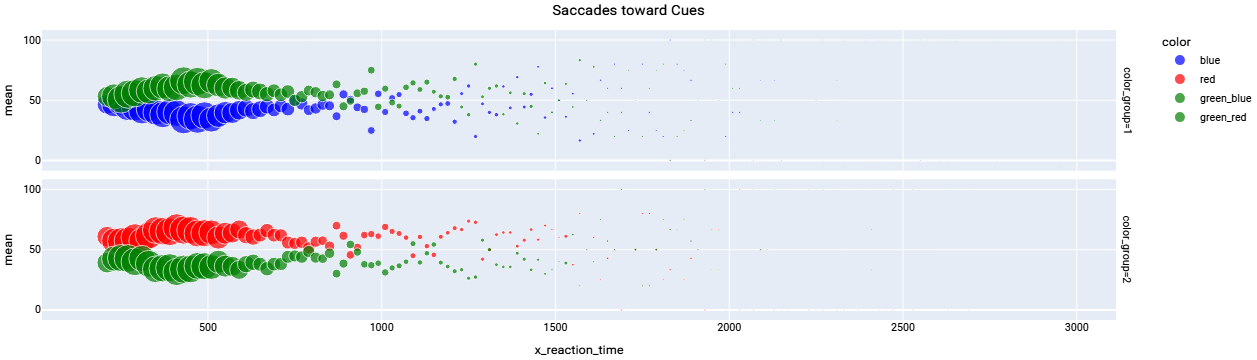

In [37]:
saccad_df = events_df[events_df["color"] != "green"]
temp_df = saccad_df.groupby(["x_reaction_time", "color"])["saccad_toward_distractor"].agg(["count", "mean"]).reset_index()
temp_df["color_group"] = temp_df["color"].apply(lambda x: 1 if x=="blue" else 2)
rev_temp_df = temp_df.copy()
rev_temp_df["color"] = rev_temp_df["color"].apply(lambda x: "green_blue" if x=="blue" else "green_red" if x=="red" else x)
rev_temp_df["mean"] = rev_temp_df["mean"].apply(lambda x: 100 - x)
merged_df = pd.concat([temp_df, rev_temp_df])

fig = px.scatter(merged_df, title= "Saccades toward Cues", 
     x="x_reaction_time", y="mean", 
     color="color", size = "count", 
     facet_row="color_group",
     # marginal_x="histogram",
     # animation_frame="color_group",
     color_discrete_map={
        "red": "red",
        "green_red": "green",
        "blue": "blue",
        "green_blue": "green"})
fig.update_layout(
    title_x=0.5,
    font= my_font,
    margin=dict(l=30, r=0, t=30, b=30)
                )
fig.show()
Saccades_toward_cues_bytes = fig.to_image(format="png", width=1900, height=352)

# pio.write_image(fig, 'sacc.png', width=1600, height=700)

# frames = []
# for s, fr in enumerate(fig.frames):
#     fig.update(data=fr.data)
#     fig.layout.sliders[0].update(active=s)
#     frames.append(PIL.Image.open(io.BytesIO(fig.to_image(scale=2, format="png"))))
    
# # create animated GIF
# frames[0].save(
#         "test.gif",
#         save_all=True,
#         append_images=frames[1:],
#         optimize=True,
#         duration=500,
#         loop=0,
#     )

## distractor presense on incorrect trials
- all data
- short latency

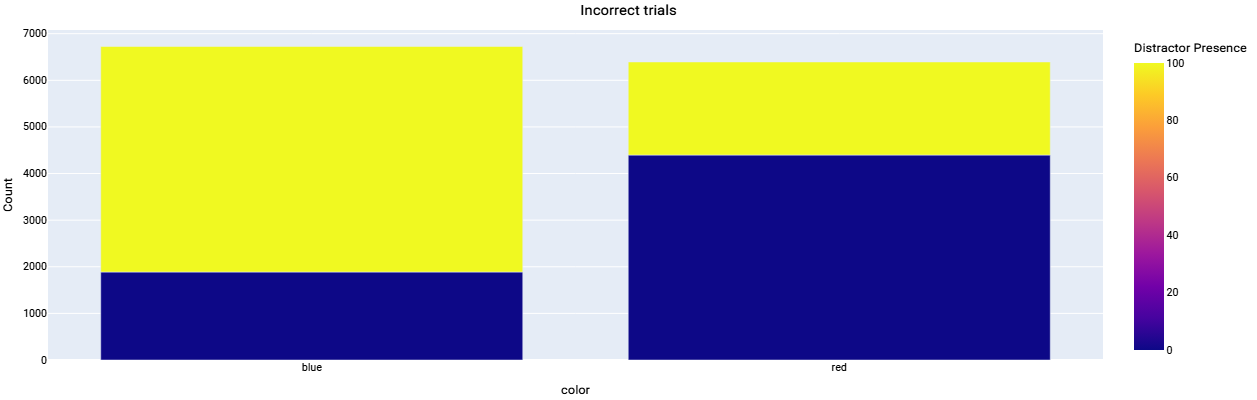

In [44]:
# Filter rows where performance = 0 or incorrect trials
sacc_df = events_df[events_df["color"] != "green"]
sacc_df = sacc_df[sacc_df['performance'] != 100]

counts = sacc_df.groupby(['distractor_presense_on_incorrect_trials', 'color']).size().reset_index(name='count')
fig = px.bar(counts, 
             x='color', y='count', 
             color='distractor_presense_on_incorrect_trials',
             title='Incorrect trials',
             labels={'distractor_presense_on_incorrect_trials': 'Distractor Presence', 'count': 'Count'},
             color_discrete_map={
             "100.0": "red",
             "0.0": "green"},
             height=400)
fig.update_layout(
    title_x=0.5,
    font= my_font,
    margin=dict(l=30, r=0, t=30, b=30))
fig.show()

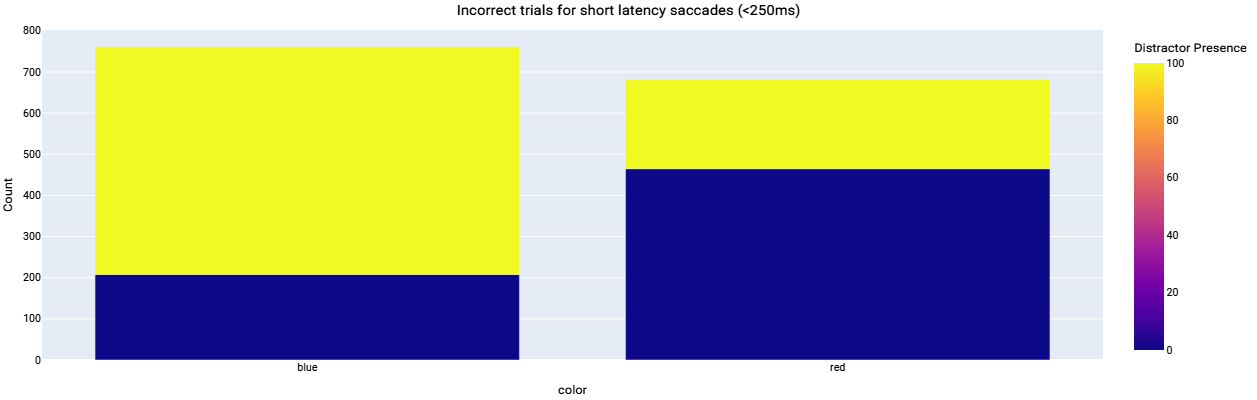

In [39]:
# Filter rows where performance = 0 for short latency saccades
sacc_df = events_df[events_df["color"] != "green"]
sacc_df = sacc_df[sacc_df['performance'] != 100]
sacc_df = sacc_df[sacc_df['reaction_time'] <= 250]

counts = sacc_df.groupby(['distractor_presense_on_incorrect_trials', 'color']).size().reset_index(name='count')
fig = px.bar(counts, 
             x='color', y='count', 
             color='distractor_presense_on_incorrect_trials',
             title='Incorrect trials for short latency saccades (<250ms)',
             labels={'distractor_presense_on_incorrect_trials': 'Distractor Presence', 'count': 'Count'},
             height=400)
fig.update_layout(
    title_x=0.5,
    font= my_font,
    margin=dict(l=30, r=0, t=30, b=30))
fig.show()

## Data points over reaction time

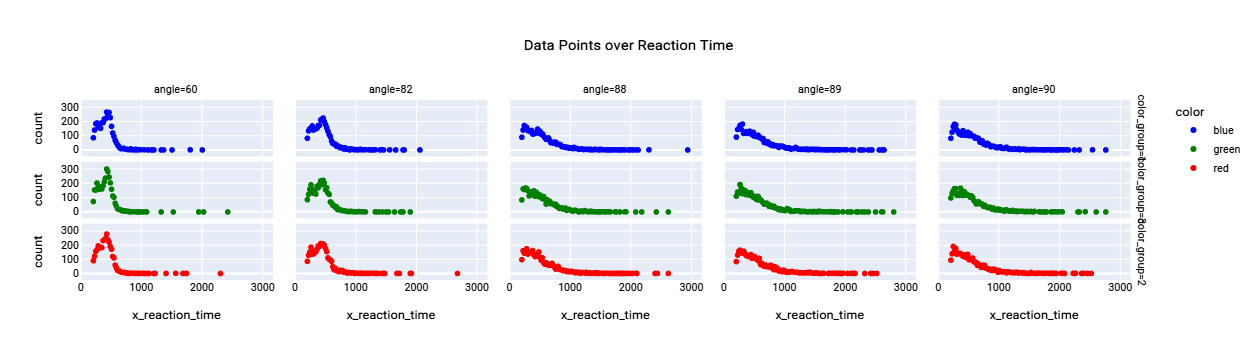

In [40]:
angle_temp_df = events_df.groupby(["x_reaction_time", "angle", "color" ])["x_reaction_time"].agg(["count", "mean"]).reset_index()
angle_temp_df["color_group"] = angle_temp_df["color"].apply(lambda x: 1 if x=="blue" else 2 if  x=="red" else 3)
angle_temp_df["angle_group"] = angle_temp_df["angle"].apply(lambda x: 1 if x=="60" else 2 if  x=="82" else 3 if x=="88" else 4 if x=="89" else 5 )
fig = px.scatter(angle_temp_df, title= "Data Points over Reaction Time", x="x_reaction_time", y="count", color="color", facet_col="angle" ,facet_row="color_group", color_discrete_map={
                "red": "red",
                "green": "green",
                "blue": "blue"})

pio.write_image(fig, 'data_points.png', width=1600, height=700)
fig.update_layout(
    title_x=0.5,
    font= my_font,
                )
fig.show()

## reaction time points

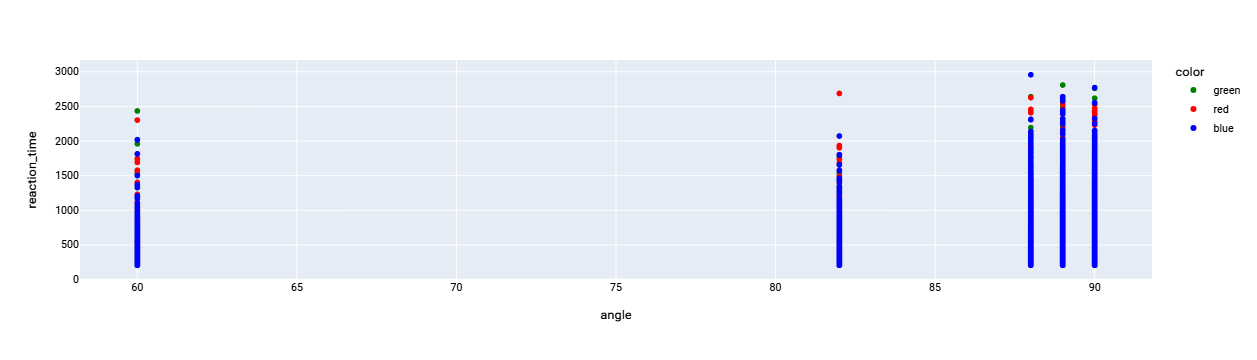

In [41]:
# filter_group = quantile_outlier_filter("reaction_time", lower_q=0.1)
# single_filter_df = events_df.groupby(["color", "angle"]).apply(filter_group).drop(columns=["color", "angle"]).reset_index()
# single_filter_df = events_df.groupby(["color", "angle"]).drop(columns=["color", "angle"]).reset_index()
single_filter_df = events_df.copy()
fig = px.scatter(single_filter_df, x="angle", y="reaction_time", color="color", color_discrete_map={
                "red": "red",
                "green": "green",
                "blue": "blue"})
fig.update_layout(
    title_x=0.5,
    font= my_font,
                )
fig.show()

## Performance over reaction time
- using weigted filter outlier for regression 

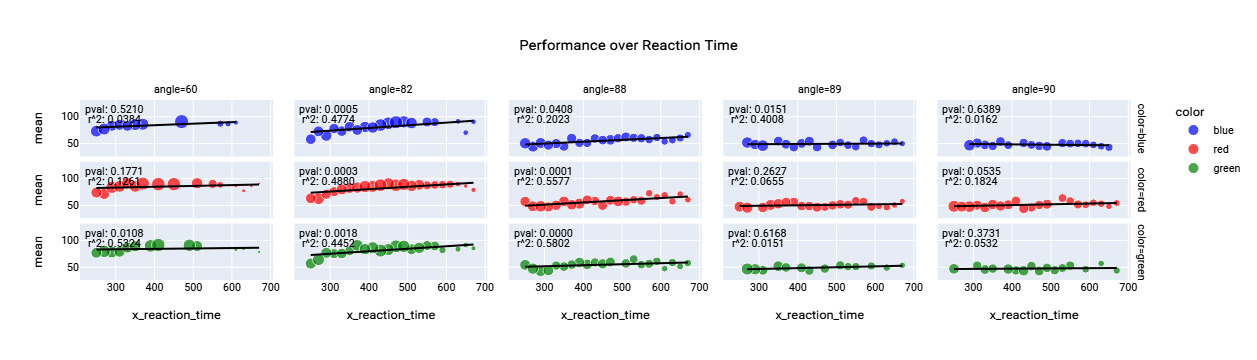

In [42]:
perf_angle_df = events_df.groupby(["x_reaction_time", "color", "angle"])["performance"] \
    .agg(["count", "mean"]).reset_index()
perf_angle_df = weigted_outlier_filter("mean", "count", lower_q=.1, upper_q=.9)(perf_angle_df)
perf_angle_df = weigted_outlier_filter("x_reaction_time", "count", lower_q=.1, upper_q=.85)(perf_angle_df)
fig = px.scatter(perf_angle_df.sort_values("angle"), 
    title="Performance over Reaction Time",
    x="x_reaction_time", y="mean", 
    color="color", size="count", size_max=10,
    facet_row="color", facet_col="angle",
    render_mode="svg",
    # marginal_x="histogram",
    # animation_frame="angle",
    # facet_col_spacing=.25, facet_row_spacing=.1,
    trendline="ols", trendline_options=dict(log_x=False), trendline_color_override="black",
    color_discrete_map={
        "red": "red",
        "green": "green",
        "blue": "blue"})
for idx, row in px.get_trendline_results(fig).sort_values("color", ascending=False).iterrows():
    res = row["px_fit_results"]
    fig.add_annotation(xref=f"x{idx+1}", yref=f"y{idx+1}", showarrow=False, yshift=30, text=f"pval: {res.pvalues[1]:.4f}")
    fig.add_annotation(xref=f"x{idx+1}", yref=f"y{idx+1}", showarrow=False, yshift=20, text=f"r^2: {res.rsquared:.4f}")
fig.update_layout(
    title_x=0.5,
    font= my_font,
                )
fig.show()
pio.write_image(fig, 'per_density.png', width=1600, height=700)


# pio.write_image(fig, 'sacc.png', width=1600, height=700)
# import PIL
# import io

# frames = []
# for s, fr in enumerate(fig.frames):
#     fig.update(data=fr.data)
#     fig.layout.sliders[0].update(active=s)
#     frames.append(PIL.Image.open(io.BytesIO(fig.to_image(scale=2, format="png"))))
    
# # create animated GIF
# frames[0].save(
#         "test.gif",
#         save_all=True,
#         append_images=frames[1:],
#         optimize=True,
#         duration=500,
#         loop=0,
#     )
# Performance_over_reaction_time_bytes = fig.to_image(format="png", width=400, height=400)

# Main Plot

In [17]:
new_merged_df = events_df.merge(perf_angle_df[["x_reaction_time"]], on='x_reaction_time', how='inner')
new_merged_df = new_merged_df.drop_duplicates()

C:\Users\mitra\AppData\Local\Temp\ipykernel_7208\666203185.py:28: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\mitra\AppData\Local\Temp\ipykernel_7208\666203185.py:29: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\mitra\AppData\Local\Temp\ipykernel_7208\666203185.py:43: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

C:\Users\mitra\AppData\Local\Temp\ipykernel_7208\666203185.py:28: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version

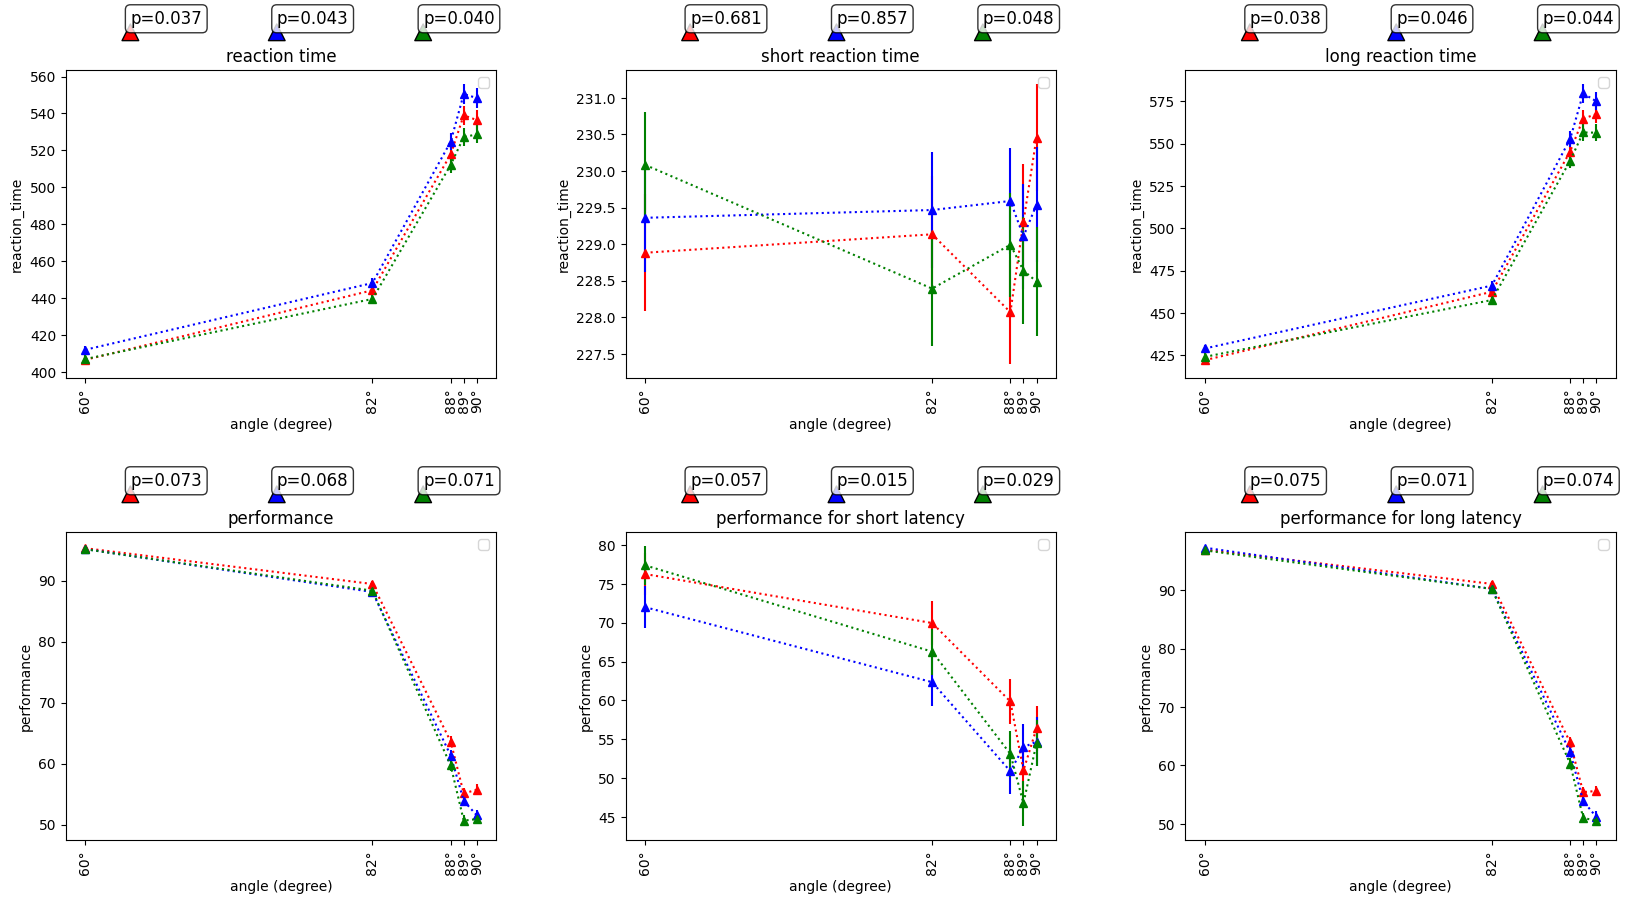

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10)) 
# reaction times
PlotInput(
    ax = axs[0,0],
    title = "reaction time", #our customized filtered reaction time
    y = "reaction_time",
    remove_outlier_rt = False,
    split = 0, 
).plot(events_df)
# single_filter_df

# short reaction times
PlotInput(
    ax = axs[0,1],
    title = "short reaction time", #our customized filtered for short reaction time
    y = "reaction_time",
    remove_outlier_rt = False,
    split = -1, #short
).plot(events_df)

# short reaction_time
PlotInput(
    ax = axs[0,2],
    title = "long reaction time", #our customized filtered for long reaction time
    y = "reaction_time",
    remove_outlier_rt = False,
    split = 1, #long
).plot(events_df)

# long reaction_time
PlotInput(
    ax = axs[1,0],
    title = "performance", #our customized filtered for performance
    y = "performance",
    remove_outlier_rt = False,
    split = 0, 
).plot(events_df)
# new_merged_df

# performance
PlotInput(
    ax = axs[1,1],
    title = "performance for short latency",
    y = "performance",
    remove_outlier_rt = False,
    split = -1, #short
).plot(events_df)

# filtered performance
PlotInput(
    ax = axs[1,2],
    title = "performance for long latency",
    y = "performance",
    remove_outlier_rt = False,
    split = 1, #long
).plot(events_df)

fig.subplots_adjust(wspace=0.3, hspace=0.5)
# fig.show()
# main_bytes = fig.to_image(format="png", width=1900, height=528)

buf = io.BytesIO()
fig.savefig(buf, format='png')
main_bytes = buf.getvalue()

# Optionally, save main_bytes as a PNG file
with open('main_image.png', 'wb') as f:
    f.write(main_bytes)

In [19]:
# fig.savefig("analysis.png")
events_df.to_csv('data.csv', index=True)

## Anova
- performance
- distractor presence
- reaction time

In [20]:
deps = ["performance", "saccad_toward_distractor", "reaction_time"]
indeps = ["color", "angle", "is_short", "color*angle", "color*is_short", "angle*is_short", "color*angle*is_short"]

f_values, p_values = [], []
detailed_results_df, detailed_results_new = {}, {}
for dependent in deps:
        formula = f"{dependent} ~ C(color, Sum) * C(angle, Sum) * is_short"
        res = ols(formula, data=events_df).fit()
        anova_table = anova_lm(res)
        f_values.append(np.round(anova_table['F'].values[:-1]))
        p_values.append(anova_table['PR(>F)'].values[:-1])

fig = px.imshow(p_values, title="ANOVA LM", x=indeps, y=deps, color_continuous_scale='Viridis', aspect="auto")
fig.update_traces(text=p_values, texttemplate="%{text:.4f}")
fig.update_xaxes(side="top")
fig.update_layout(
    title_x=0.5,
    font= my_font,
                )
# fig.show()
anova_bytes = fig.to_image(format="png", width=1000, height=300)

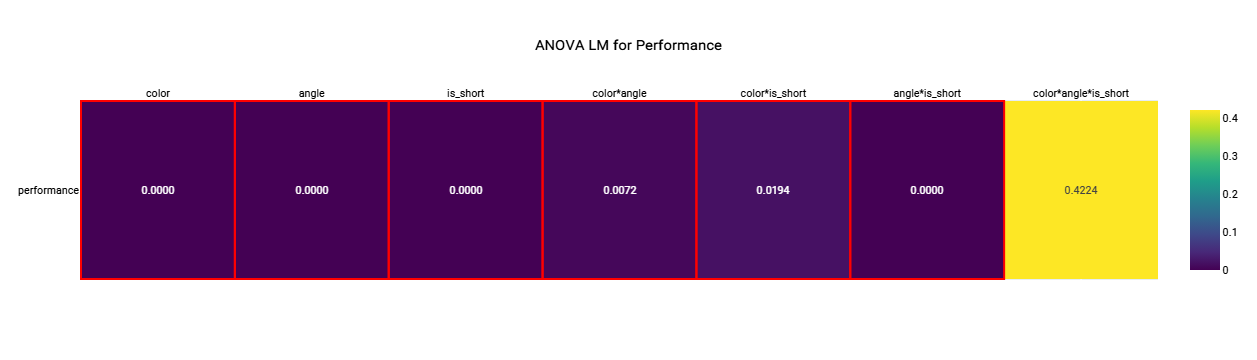

In [34]:
# deps = ["performance", "saccad_toward_distractor", "reaction_time", "distractor_presense_on_incorrect_trials"]
performance_df = events_df.copy()
deps = ["performance"]
indeps = ["color", "angle", "is_short", "color*angle", "color*is_short", "angle*is_short", "color*angle*is_short"]

f_values, p_values = [], []

for dependent in deps:
    formula = f"{dependent} ~ C(color, Sum) * C(angle, Sum) * C(is_short, Sum)"
    res = ols(formula, data=performance_df).fit()
    anova_table = anova_lm(res)
    f_values.append(np.round(anova_table['F'].values[:-1], 4))
    p_values.append(anova_table['PR(>F)'].values[:-1])

p_values_df = pd.DataFrame(p_values, index=deps, columns=indeps)
significance_df = (p_values_df < 0.05).astype(int)
fig = px.imshow(p_values_df, title="ANOVA LM for Performance", x=indeps, y=deps, color_continuous_scale='Viridis', aspect="auto")
fig.update_traces(text=p_values_df.values, texttemplate="%{text:.4f}")
fig.update_xaxes(side="top")
fig.update_layout(
    title_x=0.5,
    font=my_font,
)

# red rectangles for significant effects
for i, dep in enumerate(deps):
    for j, indep in enumerate(indeps):
        if significance_df.iloc[i, j] == 1:
            fig.add_shape(type="rect",
                          x0=j - 0.5, x1=j + 0.5,
                          y0=i - 0.5, y1=i + 0.5,
                          line=dict(color="red", width=2))

fig.update_xaxes(side="top")
fig.update_layout(
    title_x=0.5,
    font=my_font,
)

fig.show()
anova_bytes = fig.to_image(format="png", width=1000, height=300)
# display(significance_df)

In [33]:
# if SIG
from statsmodels.stats.multicomp import MultiComparison

def perform_tukey_hsd(df, dependent_var, independent_var):
    mc = MultiComparison(df[dependent_var], df[independent_var])
    result = mc.tukeyhsd()
    result_df = pd.DataFrame(result._results_table.data[1:], columns=result._results_table.data[0])
    return result_df

def handle_interaction(df, dependent_var, interaction):
    vars_involved = interaction.split('*')
    
    if len(vars_involved) == 2:
        results_dfs = []
        for level in df[vars_involved[0]].unique():
            subset_df = df[df[vars_involved[0]] == level]
            mc = MultiComparison(subset_df[dependent_var], subset_df[vars_involved[1]])
            result = mc.tukeyhsd()
            result_df = pd.DataFrame(result._results_table.data[1:], columns=result._results_table.data[0])
            result_df['Subset'] = f"{vars_involved[0]}={level}"  
            results_dfs.append(result_df)
        
        
        combined_result_df = pd.concat(results_dfs, ignore_index=True)
        return combined_result_df

significant_effects = []

# Iterate over the rows (dependent variables) and columns (independent variables)
for dep_var in significance_df.index:
    for indep_var in significance_df.columns:
        # Check if the effect is significant
        if significance_df.loc[dep_var, indep_var] == 1:
            significant_effects.append((dep_var, indep_var))



results_dfs = []  #

for dep_var, indep_var in significant_effects:
    if '*' not in indep_var:  # Main effect
        result_df = perform_tukey_hsd(performance_df, dep_var, indep_var)
        result_df['Effect'] = f"{dep_var} ~ {indep_var}"  
        results_dfs.append(result_df)
    else:  # Interaction
        result_df = handle_interaction(performance_df, dep_var, indep_var)
        result_df['Effect'] = f"{dep_var} ~ {indep_var}" 
        results_dfs.append(result_df)

combined_results_df = pd.concat(results_dfs, ignore_index=True)

# Display the combined results
# display(combined_results_df)
combined_results_df.to_csv('performance_posthoc.csv', index=True)

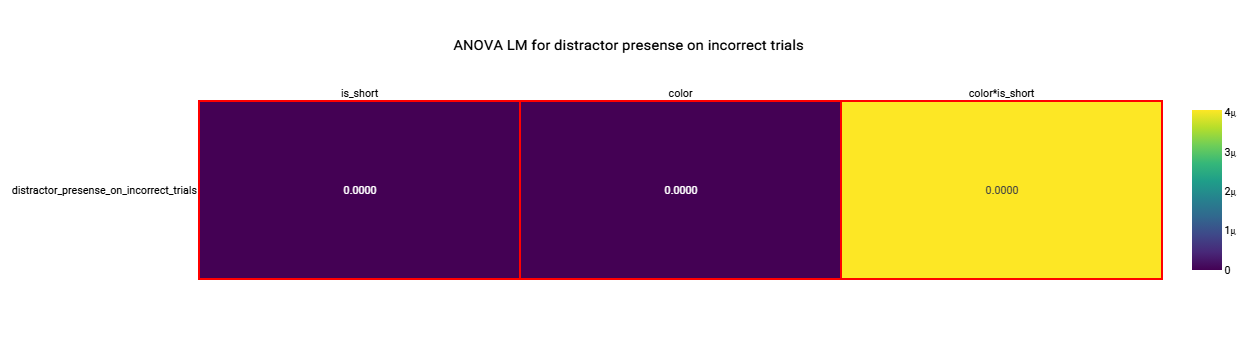

In [35]:
without_green_df = events_df[events_df['color'] != 'green']
deps = ["distractor_presense_on_incorrect_trials"]
indeps = ["is_short" , "color", "color*is_short"]

f_values, p_values = [], []


for dependent in deps:
    formula = f"{dependent} ~ C(is_short, Sum) * C(color, Sum)"
    res = ols(formula, data=without_green_df).fit()
    anova_table = anova_lm(res)
    f_values.append(np.round(anova_table['F'].values[:-1], 4))
    p_values.append(anova_table['PR(>F)'].values[:-1])


p_values_df = pd.DataFrame(p_values, index=deps, columns=indeps)


significance_df = (p_values_df < 0.05).astype(int)

fig = px.imshow(p_values_df, title="ANOVA LM for distractor presense on incorrect trials", x=indeps, y=deps, color_continuous_scale='Viridis', aspect="auto")
fig.update_traces(text=p_values_df.values, texttemplate="%{text:.4f}")
fig.update_xaxes(side="top")
fig.update_layout(
    title_x=0.5,
    font=my_font,
)

# Add red rectangles for significant effects
for i, dep in enumerate(deps):
    for j, indep in enumerate(indeps):
        if significance_df.iloc[i, j] == 1:
            fig.add_shape(type="rect",
                          x0=j - 0.5, x1=j + 0.5,
                          y0=i - 0.5, y1=i + 0.5,
                          line=dict(color="red", width=2))

fig.update_xaxes(side="top")
fig.update_layout(
    title_x=0.5,
    font=my_font,
)

fig.show()
anova_bytes = fig.to_image(format="png", width=1000, height=300)
# display(significance_df)

In [32]:
# if SIG
from statsmodels.stats.multicomp import MultiComparison

# Modified function to perform Tukey's HSD and return results as DataFrame
def perform_tukey_hsd(df, dependent_var, independent_var):
    mc = MultiComparison(df[dependent_var], df[independent_var])
    result = mc.tukeyhsd()
    # Convert result to DataFrame for easier manipulation
    result_df = pd.DataFrame(result._results_table.data[1:], columns=result._results_table.data[0])
    return result_df

# Modified function to handle interactions and return results as DataFrame
def handle_interaction(df, dependent_var, interaction):
    vars_involved = interaction.split('*')
    
    # Example for handling a two-way interaction
    if len(vars_involved) == 2:
        results_dfs = []
        for level in df[vars_involved[0]].unique():
            subset_df = df[df[vars_involved[0]] == level]
            mc = MultiComparison(subset_df[dependent_var], subset_df[vars_involved[1]])
            result = mc.tukeyhsd()
            result_df = pd.DataFrame(result._results_table.data[1:], columns=result._results_table.data[0])
            result_df['Subset'] = f"{vars_involved[0]}={level}"  # Add information about the subset
            results_dfs.append(result_df)
        
        # Concatenate all DataFrames for the interaction
        combined_result_df = pd.concat(results_dfs, ignore_index=True)
        return combined_result_df

# Assuming significant_effects is already defined
significant_effects = []

# Iterate over the rows (dependent variables) and columns (independent variables)
for dep_var in significance_df.index:
    for indep_var in significance_df.columns:
        # Check if the effect is significant
        if significance_df.loc[dep_var, indep_var] == 1:
            # Append the tuple of dependent and independent variable to the list
            significant_effects.append((dep_var, indep_var))

results_dfs = []  # List to hold DataFrames of results

for dep_var, indep_var in significant_effects:
    if '*' not in indep_var:  # Main effect
        result_df = perform_tukey_hsd(without_green_df, dep_var, indep_var)
        result_df['Effect'] = f"{dep_var} ~ {indep_var}"  # Add information about the effect tested
        results_dfs.append(result_df)
    else:  # Interaction
        result_df = handle_interaction(without_green_df, dep_var, indep_var)
        result_df['Effect'] = f"{dep_var} ~ {indep_var}"  # Add information about the interaction tested
        results_dfs.append(result_df)

# Combine all results into a single DataFrame
combined_results_df = pd.concat(results_dfs, ignore_index=True)

# Display the combined results
# display(combined_results_df)
combined_results_df.to_csv('distractor_presense_on_incorrect_trials_posthoc.csv', index=True)

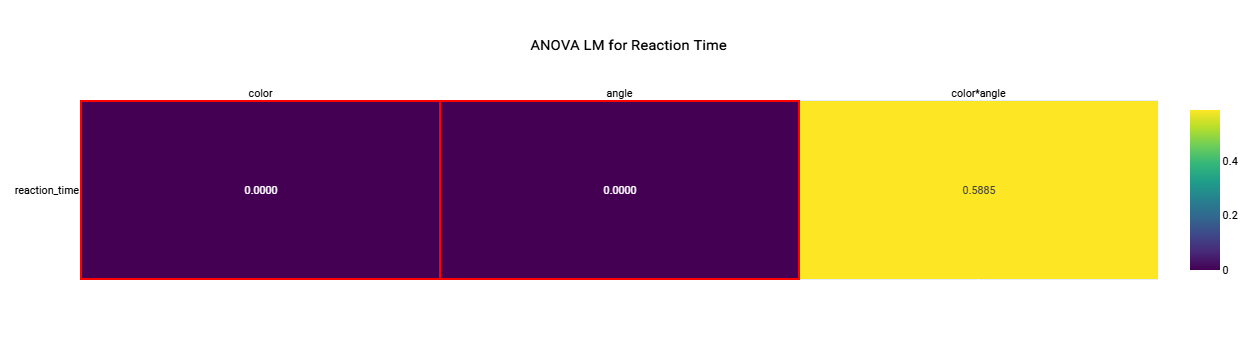

In [30]:
# deps = ["performance", "saccad_toward_distractor", "reaction_time", "distractor_presense_on_incorrect_trials"]
reaaction_time_df = events_df.copy()
deps = ["reaction_time"]
indeps = ["color", "angle","color*angle"]

f_values, p_values = [], []

# Calculate F-values and p-values
for dependent in deps:
    formula = f"{dependent} ~ C(color, Sum) * C(angle, Sum)"
    res = ols(formula, data=reaaction_time_df).fit()
    anova_table = anova_lm(res)
    f_values.append(np.round(anova_table['F'].values[:-1], 4))
    p_values.append(anova_table['PR(>F)'].values[:-1])

# Convert p_values to a DataFrame
p_values_df = pd.DataFrame(p_values, index=deps, columns=indeps)

# Create a significance_df based on p-value threshold (e.g., 0.05)
significance_df = (p_values_df < 0.05).astype(int)

# Plot heatmap
fig = px.imshow(p_values_df, title="ANOVA LM for Reaction Time", x=indeps, y=deps, color_continuous_scale='Viridis', aspect="auto")
fig.update_traces(text=p_values_df.values, texttemplate="%{text:.4f}")
fig.update_xaxes(side="top")
fig.update_layout(
    title_x=0.5,
    font=my_font,
)

# Add red rectangles for significant effects
for i, dep in enumerate(deps):
    for j, indep in enumerate(indeps):
        if significance_df.iloc[i, j] == 1:
            fig.add_shape(type="rect",
                          x0=j - 0.5, x1=j + 0.5,
                          y0=i - 0.5, y1=i + 0.5,
                          line=dict(color="red", width=2))

fig.update_xaxes(side="top")
fig.update_layout(
    title_x=0.5,
    font=my_font,
)

fig.show()
anova_bytes = fig.to_image(format="png", width=1000, height=300)
# display(significance_df)

In [36]:
# if SIG
from statsmodels.stats.multicomp import MultiComparison

# function to perform Tukey's HSD and return results as DF
def perform_tukey_hsd(df, dependent_var, independent_var):
    mc = MultiComparison(df[dependent_var], df[independent_var])
    result = mc.tukeyhsd()
    # Convert result to DataFrame for easier manipulation
    result_df = pd.DataFrame(result._results_table.data[1:], columns=result._results_table.data[0])
    return result_df

# function to handle interactions and return results as DF
def handle_interaction(df, dependent_var, interaction):
    vars_involved = interaction.split('*')
    if len(vars_involved) == 2:
        results_dfs = []
        for level in df[vars_involved[0]].unique():
            subset_df = df[df[vars_involved[0]] == level]
            mc = MultiComparison(subset_df[dependent_var], subset_df[vars_involved[1]])
            result = mc.tukeyhsd()
            result_df = pd.DataFrame(result._results_table.data[1:], columns=result._results_table.data[0])
            result_df['Subset'] = f"{vars_involved[0]}={level}"  
            results_dfs.append(result_df)
        
        
        combined_result_df = pd.concat(results_dfs, ignore_index=True)
        return combined_result_df


significant_effects = []


for dep_var in significance_df.index:
    for indep_var in significance_df.columns:
        # Check if significant
        if significance_df.loc[dep_var, indep_var] == 1:
            
            significant_effects.append((dep_var, indep_var))

results_dfs = [] 

for dep_var, indep_var in significant_effects:
    if '*' not in indep_var:  # Main effect
        result_df = perform_tukey_hsd(reaaction_time_df, dep_var, indep_var)
        result_df['Effect'] = f"{dep_var} ~ {indep_var}"  
        results_dfs.append(result_df)
    else:  # Interaction
        result_df = handle_interaction(reaaction_time_df, dep_var, indep_var)
        result_df['Effect'] = f"{dep_var} ~ {indep_var}" 
        results_dfs.append(result_df)

combined_results_df = pd.concat(results_dfs, ignore_index=True)

# Display the combined results
# display(combined_results_df)
combined_results_df.to_csv('rt_posthoc.csv', index=True)

## Main effects

C:\Users\mitra\AppData\Local\Temp\ipykernel_7208\2483185221.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\mitra\AppData\Local\Temp\ipykernel_7208\2483185221.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




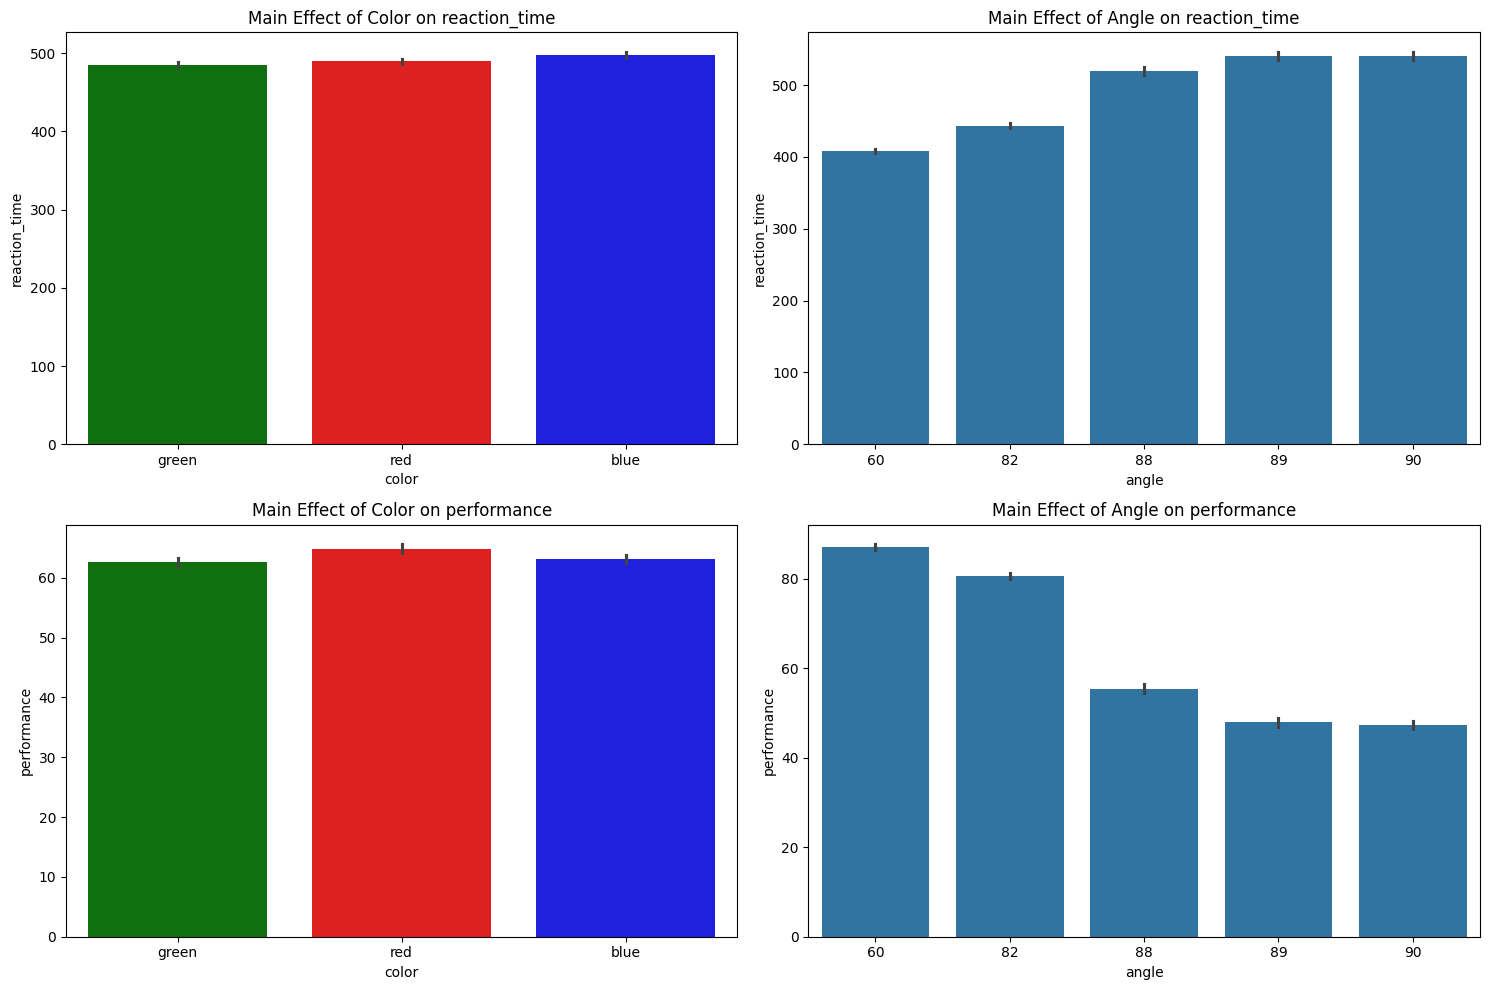

In [28]:
deps = ['reaction_time', 'performance'] 
color_palette = {'red': 'red', 'blue': 'blue', 'green': 'green'}

fig, axes = plt.subplots(len(deps), 2, figsize=(15, 5 * len(deps)))

for i, dep in enumerate(deps):
    if axes.ndim == 2:  # If axes is 2D
        ax_main = axes[i, 0]
        ax_angle = axes[i, 1]
    else:  # If axes is 1D
        ax_main = axes
        ax_angle = None
    
    # Main effect for 'color'
    sns.barplot(data=events_df, x='color', y=dep, ax=ax_main, legend=False, palette=color_palette)
    ax_main.set_title(f'Main Effect of Color on {dep}')
    
    # Main effect for 'angle'
    if ax_angle:
        sns.barplot(data=events_df, x='angle', y=dep, ax=ax_angle)
        ax_angle.set_title(f'Main Effect of Angle on {dep}')

plt.tight_layout()
plt.show()

# Concat figs in one png

In [29]:
from PIL import Image, ImageDraw, ImageFont
import io
im1 = Image.open(io.BytesIO(Saccades_toward_cues_bytes)).resize((1200, 300))
im2 = Image.open(io.BytesIO(main_bytes)).resize((1500, 500))
im3 = Image.open(io.BytesIO(anova_bytes))
im4 = Image.open("far.png").resize((150, 150)) #rename the png with the desired task frame 

def get_concat_v():
    dst = Image.new("RGB", (1600,1080), (255, 255, 255))
    dst.paste(im3, (300, 5))
    dst.paste(im2, (50, im3.height-50))
    dst.paste(im1, (250, im3.height+im2.height-33))
    dst.paste(im4, (1420, 30))
    
    draw = ImageDraw.Draw(dst)
    text1 = "Training" #rename the title for test phase or training phase
    font = ImageFont.truetype("arial.ttf", 20)  # font and size
    draw.text((10, 10), text1, fill=(0, 0, 0), font=font)
    text2 = "Task:"
    draw.text((1420, 8), text2, fill=(0, 0, 0), font=font)
    return dst
    
get_concat_v().save("concat.png")